GD         | x0=-1.0 | eta=0.05 | gamma=None | final_gap=6.9389e-18 | best_so_far_gap=0.0000e+00 | time_to_tol=17
GD         | x0=-1.0 | eta=0.1 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=8
GD         | x0=-1.0 | eta=0.15 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=4
GD         | x0=-1.0 | eta=0.2 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=2
GD-backtrack | x0=-1.0 | eta=0.05 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=17
GD-backtrack | x0=-1.0 | eta=0.1 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=8
GD-backtrack | x0=-1.0 | eta=0.15 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=4
GD-backtrack | x0=-1.0 | eta=0.2 | gamma=None | final_gap=0.0000e+00 | best_so_far_gap=0.0000e+00 | time_to_tol=2
SGD-const  | x0=-1.0 | eta=0.05 | gamma=None | final_gap=3.1344e-05 | best_so_far_gap=3.04

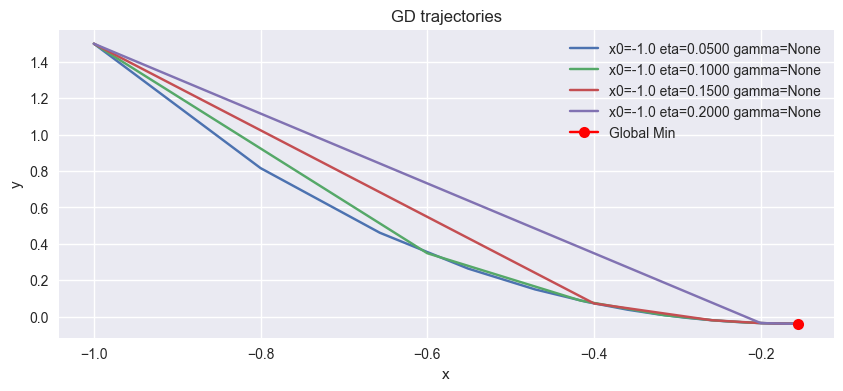

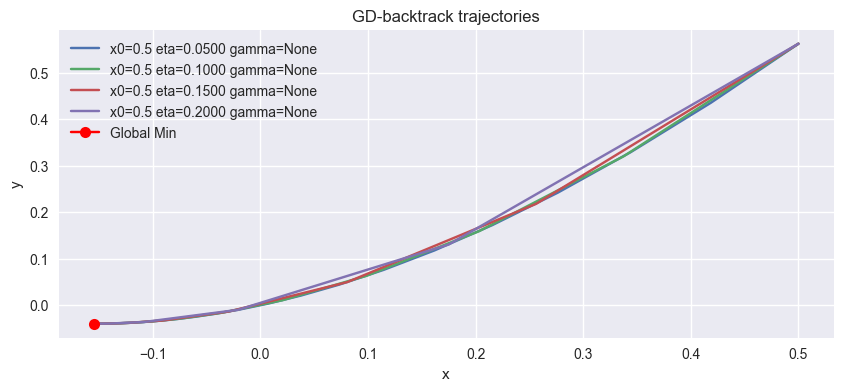

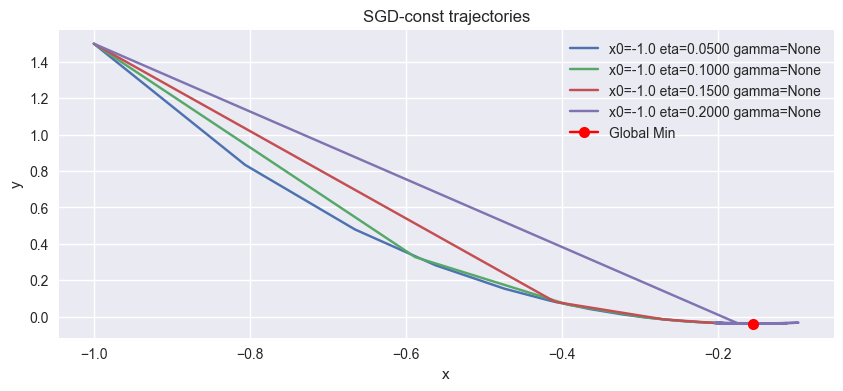

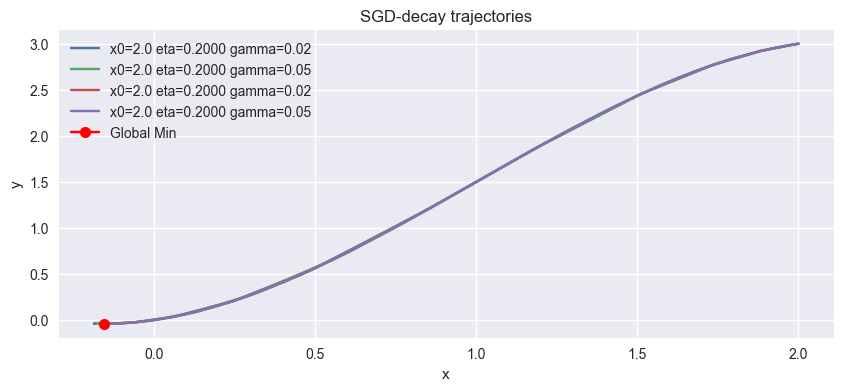

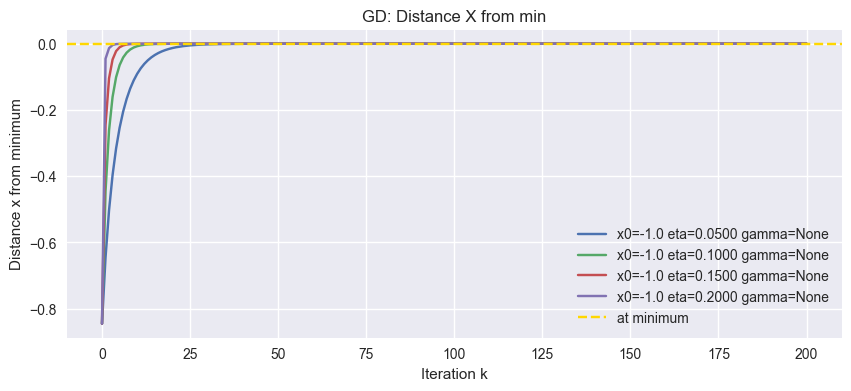

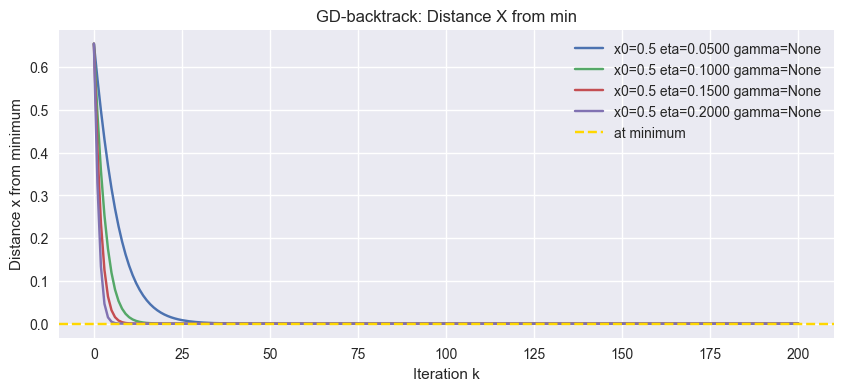

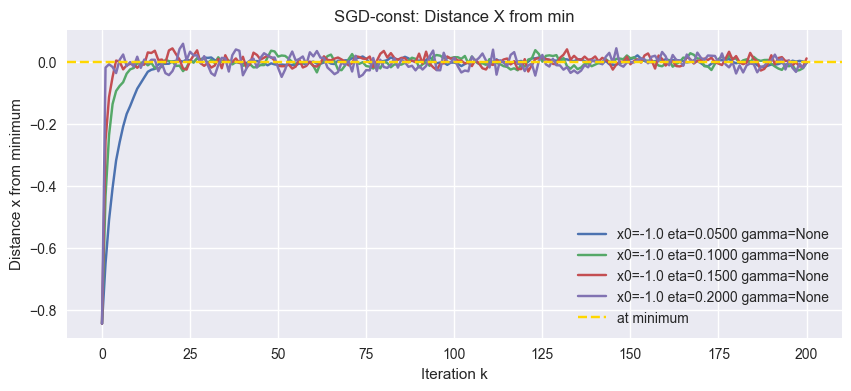

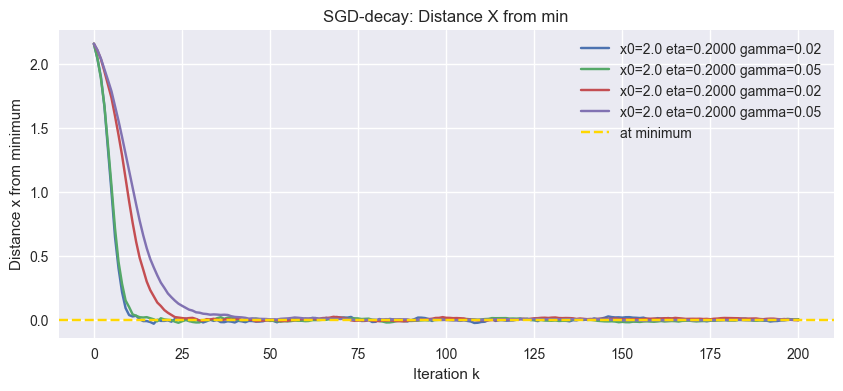

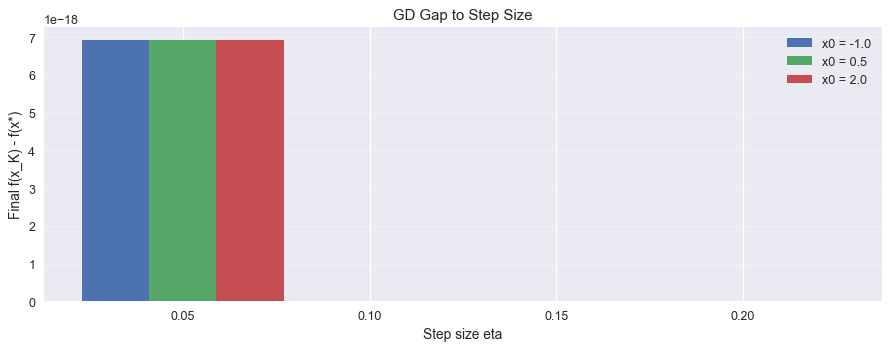

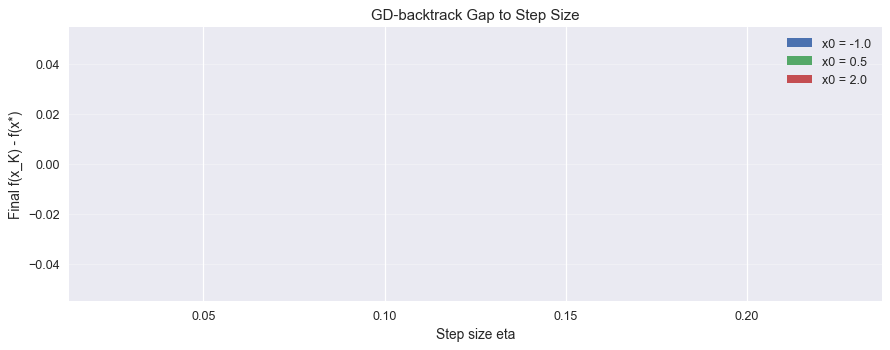

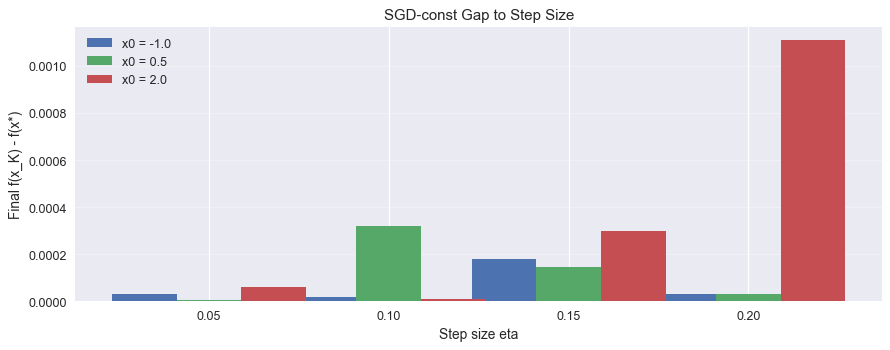

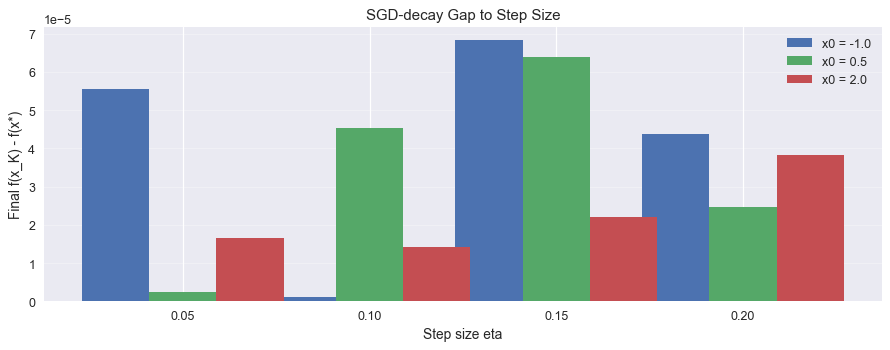

The noise increases with eta, lower eta is slow to converge but have lesser noise when they get close to the min


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.style.use('seaborn-v0_8')

# ---------------------------------------------------------
# Experiment parameters
# ---------------------------------------------------------
x0_list = [-1.0, 0.5, 2.0]
eta_list = [0.05, 0.10, 0.15, 0.20]
eta0_sgd_list = [0.2, 0.1]
gamma_sgd_list = [0.02, 0.05]
K = 200


# ---------------------------------------------------------
#  Target function: 
#   f(x) = |g(x)| + 0.5x
#     where g(x) = 0.5x^3 - 1.5x^2
# ---------------------------------------------------------
def g(x):
    x = np.asarray(x)
    return 0.5 * x**3 - 1.5 * x**2

def f(x):
    x = np.asarray(x)
    return np.abs(g(x)) + 0.5 * x

# ---------------------------------------------------------
#  f prime
#  f(x) = |g(x)| + 0.5x is piecewise differentiable:
#  If g(x) < 0:  f'(x) = -(g'(x)) + 0.5
#  If g(x) > 0:  f'(x) =  (g'(x)) + 0.5
# ---------------------------------------------------------
def df(x):
    x = np.asarray(x)

    # g'(x)
    gp = 1.5*x**2 - 3*x

    # sign(g(x)) is -1 for x<3, +1 for x>3, x=0 sign is irrevalent as g(0)=0
    sign = np.where(x < 3, -1.0, 1.0)

    # derivative of |g(x)| is s * g'(x), except at x=3
    # but f'(x) exists everywhere because of +0.5*x
    abs_gp = sign * gp

    # override undefined |g(3)|
    abs_gp = np.where(x == 3, 0.0, abs_gp)

    return abs_gp + 0.5 #@TODO: recheck if is this correct for x=3 as g(3) is undefined
    
# ---------------------------------------------------------
#  f hessian/curvature/2nd derivative
# ---------------------------------------------------------
def d2f(x):
    x = np.asarray(x)
    f2 = 3*x - 3
    sign = np.where(x < 3, -1.0, 1.0)
    abs_f2 = sign * f2

    # f''(3) does not exist → return np.nan
    out = np.where(x == 3, np.nan, abs_f2)
    
    return abs_f2

# ---------------------------------------------------------
# Gradient Descent
# ---------------------------------------------------------
def simulate_gd(x0, eta, K):
    xs = [x0]
    ys = [f(x0)]
    
    for _ in range(K):
        x = xs[-1]
        grad = df(x)
        x = x - eta * grad
        
        xs.append(x)
        ys.append(f(x))
        
    return np.stack(xs),np.stack(ys)

# ---------------------------------------------------------
# Gradient Descent with backtracking
# ---------------------------------------------------------
def simulate_gd_backtracking(x0, eta, K, beta=0.5, c=1e-4):    
    xs = [x0]
    ys = [f(x0)]
    
    for _ in range(K):
        x = xs[-1]
        grad = df(x)
        t = eta
        grad2 = grad*grad
            
        # Armijo condition: f(x - t grad) <= f(x) - c t ||grad||^2
        while f(x - t*grad) > f(x) - c * t * grad2:
            t *= beta
    
        x = x - t*grad        
        
        xs.append(x)
        ys.append(f(x))
    
    return np.stack(xs),np.stack(ys)

# ---------------------------------------------------------
# Stochastic Gradient Descent
# ---------------------------------------------------------
def simulate_sgd(x0,  eta, K, noise):
    xs = [x0]
    ys = [f(x0)]

    for k in range(K):   
        eta_k = eta if np.isscalar(eta) else eta[k]
        eps_k = eps if np.isscalar(noise) else noise[k]
        
        x = xs[-1]        
        grad = df(x)
        x = x - (eta_k * (grad + eps_k))
        y = f(x)
        
        xs.append(x)
        ys.append(f(x))
        
    return np.stack(xs),np.stack(ys)
    
# ---------------------------------------------------------
# Metrics
# ---------------------------------------------------------
def compute_metrics(ys, ys_min, tol=0.001):
    final_gap = ys[-1] - ys_min
    best_gap = np.min(ys - ys_min)

    # time to reach tolerance
    idx = np.where(ys - ys_min <= tol)[0]
    time_to_tol = idx[0] if len(idx) > 0 else None

    return {
        "final_gap": final_gap,
        "best_so_far_gap": best_gap,
        "time_to_tol": time_to_tol
    }

# ---------------------------------------------------------
# Set the global min
# ---------------------------------------------------------
global_min = -0.15470053837925152
f_global_min = f(global_min)
rng = np.random.default_rng(27)

# ---------------------------------------------------------
# Run all experiments
# ---------------------------------------------------------
results = []
ts = []

for x0 in x0_list:

    # ----- GD with constant eta -----
    for eta in eta_list:
        xs, ys = simulate_gd(x0, eta, K)
        metrics = compute_metrics(ys, ys_min=f_global_min)
        results.append(("GD", x0, eta, None, metrics))
        if x0 == -1.0:
            ts.append(("GD", x0, eta, None, (xs,ys)))

    # ----- GD(backtracking) with constant eta -----
    for eta in eta_list:
        xs, ys = simulate_gd_backtracking(x0, eta, K)
        metrics = compute_metrics(ys, ys_min=f_global_min)
        results.append(("GD-backtrack", x0, eta, None, metrics))
        if x0 == 0.5:
            ts.append(("GD-backtrack", x0, eta, None, (xs,ys)))

    # ----- SGD with constant eta -----
    for eta in eta_list:
        noise = rng.normal(0, 0.1, K)   # choose noise level
        xs, ys = simulate_sgd(x0, eta, K, noise)
        metrics = compute_metrics(ys, ys_min=f_global_min)
        results.append(("SGD-const", x0, eta, None, metrics))
        if x0 ==-1:
            ts.append(("SGD-const", x0, eta, None, (xs,ys)))

    # ----- SGD with decaying eta_k -----
    for eta0 in eta0_sgd_list:
        for gamma in gamma_sgd_list:
            eta_schedule = np.array([eta0 / (1 + gamma*k) for k in range(K)])
            noise = rng.normal(0, 0.1, K)
            xs, ys = simulate_sgd(x0, eta_schedule, K, noise)
            metrics = compute_metrics(ys, ys_min=f_global_min)
            results.append(("SGD-decay", x0, eta0, gamma, metrics))
            if x0 ==2:
                ts.append(("SGD-decay", x0, eta, gamma, (xs,ys)))

# ---------------------------------------------------------
# Print results
# ---------------------------------------------------------
for method, x0, eta, gamma, metrics in results:
    print(f"{method:10s} | x0={x0:4.1f} | eta={eta} | gamma={gamma} | "
          f"final_gap={metrics['final_gap']:.4e} | "
          f"best_so_far_gap={metrics['best_so_far_gap']:.4e} | "
          f"time_to_tol={metrics['time_to_tol']}")


# ---------------------------------------------------------------------------
# Plot GD trajectories
#
# Shows the optimization path (x_k, f(x_k)) for each run of a given method.
# Each curve is a trajectory starting from some x0 with a specific (eta, gamma).
# Useful for visualizing how different step sizes or momentum values move
# through the landscape and whether they overshoot, oscillate, or converge.
# ---------------------------------------------------------------------------
def plot_gradient_descent(name):
    gd_results = [r for r in ts if r[0] == name]
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    for method, x0, eta, gamma, (x,y) in gd_results:
        ax.plot(x, y, label=f"x0={x0} eta={eta:.4f} gamma={gamma}")        
    
    ax.plot(global_min, f_global_min, marker='o', color='red', markersize=8, label='Global Min') 
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"{name} trajectories")
    ax.grid(True)
    ax.legend()

# ---------------------------------------------------------
# Plot Distance(x) from minimum
# ---------------------------------------------------------
def plot_distance_x_from_min(name):
    gd_results = [r for r in ts if r[0] == name]
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    for method, x0, eta, gamma, (x,y) in gd_results:
        ax.plot(x-global_min, label=f"x0={x0} eta={eta:.4f} gamma={gamma}") 
    
    ax.axhline(0.0, color="gold", linestyle="--", label="at minimum")
    ax.set_xlabel("Iteration k")
    ax.set_ylabel("Distance x from minimum")
    ax.legend()
    ax.set_title(f"{name}: Distance X from min")
    ax.grid(True)
    plt.show()
    
# ---------------------------------------------------------
# Plot Final Gap
# ---------------------------------------------------------
def plot_final_gap(name):
    gd_results = [r for r in results if r[0] == name]
    
    # Group results by x0
    by_x0 = {}
    for method, x0, eta, _, metrics in gd_results:
        if x0 not in by_x0:
            by_x0[x0] = {"eta": [], "final_gap": []}
        by_x0[x0]["eta"].append(eta)
        by_x0[x0]["final_gap"].append(metrics["final_gap"])
    
    # Plot 
    fig, ax = plt.subplots(figsize=(10, 4), dpi=90)
    
    width = 0.018  # bar width
    offsets = np.linspace(-width, width, len(by_x0))  # separate groups
    
    etas_sorted = sorted(eta_list)  # consistent x-axis order
    
    for offset, (x0, data) in zip(offsets, by_x0.items()):
        # Sort by eta
        order = np.argsort(data["eta"])
        etas = np.array(data["eta"])[order]
        gaps = np.array(data["final_gap"])[order]
    
        # Align bars to the sorted eta_list
        ax.bar(
            np.array(etas_sorted) + offset,
            gaps,
            width=width,
            label=f"x0 = {x0}"
        )
    
    ax.set_xlabel("Step size eta")
    ax.set_ylabel("Final f(x_K) - f(x*)")
    #ax.set_yscale("log")
    ax.set_title(f"{name} Gap to Step Size")
    ax.grid(True, axis="y", alpha=0.3)
    ax.set_xticks(etas_sorted)
    ax.legend()
    
    fig.tight_layout()
    plt.show()

def plot(p):
    p("GD")
    p("GD-backtrack")
    p("SGD-const")
    p("SGD-decay")

plot(plot_gradient_descent)
print("\nLower eta converges into the min quicker")

plot(plot_distance_x_from_min)
plot(plot_final_gap)
print("The noise increases with eta, lower eta is slow to converge but have lesser noise when they get close to the min")


